In [346]:
from utils import make_need_tree,visualize_tree,make_storage,make_requirement_tree,make_task_list
# visual test_tasks with gantt chart
import plotly.express as px
import pandas as pd


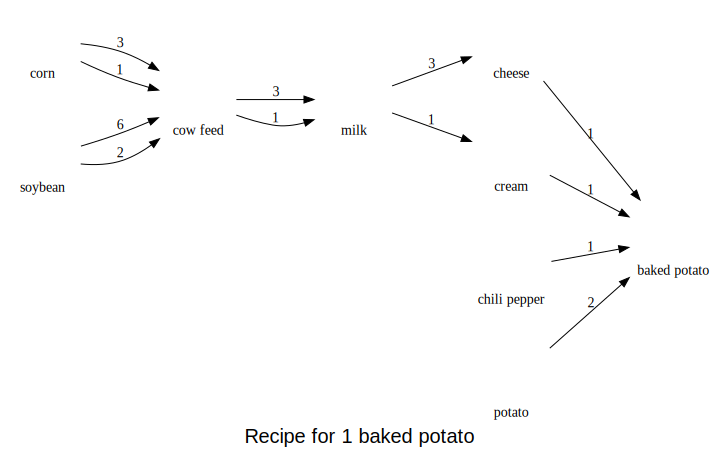

In [347]:
name='baked potato'
tree = make_need_tree(name,1)
visualize_tree(tree)

In [348]:
storage = make_storage()
req_tree=make_requirement_tree(name,storage)
req_tree

{'name': 'baked potato',
 'quantity': 1,
 'children': [{'name': 'cheese',
   'quantity': 1,
   'children': [{'name': 'milk',
     'quantity': 3,
     'children': [{'name': 'cow feed',
       'quantity': 3,
       'children': [{'name': 'corn', 'quantity': 3, 'children': []},
        {'name': 'soybean', 'quantity': 6, 'children': []}]}]}]},
  {'name': 'chili pepper', 'quantity': 1, 'children': []},
  {'name': 'cream',
   'quantity': 1,
   'children': [{'name': 'milk',
     'quantity': 1,
     'children': [{'name': 'cow feed',
       'quantity': 1,
       'children': [{'name': 'corn', 'quantity': 1, 'children': []},
        {'name': 'soybean', 'quantity': 2, 'children': []}]}]}]},
  {'name': 'potato', 'quantity': 2, 'children': []}]}

In [349]:
tasks=make_task_list(req_tree)

In [350]:
# number of machines
sources={
    'Bakery':1, 'Chicken':1, 'Feed Mill':1, 'Field':4, 'Raspberry bush':1,'Sugar Mill':1,'Cake Oven':1,
    'Cherry tree':2,'Cow':6,'BBQ Grill':1,'Dairy':1
}
machines ={}
# make machines is: key is same as sources, value is a list of machine_id
# machine_id must be unique from other machines
count  = 0
for key,value in sources.items():
    machines[key]=list(range(count,count+value))
    count+=value
machines

{'Bakery': [0],
 'Chicken': [1],
 'Feed Mill': [2],
 'Field': [3, 4, 5, 6],
 'Raspberry bush': [7],
 'Sugar Mill': [8],
 'Cake Oven': [9],
 'Cherry tree': [10, 11],
 'Cow': [12, 13, 14, 15, 16, 17],
 'BBQ Grill': [18],
 'Dairy': [19]}

In [351]:
# function to check if task b depends on task a
def check_dependency(task_a_pos,task_b_pos):
    """check if task b is in the dependencies of task a
    task_a_pos: position of task a in tasks list
    task_b_pos: position of task b in tasks list
    
    return: True if task b depends on task a, False otherwise
    """
    task_a = tasks[task_a_pos]
    task_b = tasks[task_b_pos]
    return task_b['id'] in task_a['dependencies']

In [352]:
import random

def make_chromosome(tasks,machines):
    """make a chromosome from tasks and machines
    tasks: list of task
    machines: dictionary of machines
    
    return: a chromosome (list of tuple (id,machine_id))
    id is the position of the task in the task list
    machine_id is the id of the machine
    the order of the tuple is the order of the task
    """
    chromosome=[]
    for i in range(len(tasks)):
        task=tasks[i]
        machine_id=random.choice(machines[task['source']])
        chromosome.append((i,machine_id))
    # # random shuffle the chromosome
  
    return chromosome

def chromosome_to_task_list(chromosome):
    """convert a chromosome to a task list
    chromosome: a chromosome
    
    return: a task list
    """
    task_list=[]
    for task_id,machine_id in chromosome:
        temp_task = tasks[task_id].copy()
        temp_task['machine_id']=machine_id
        task_list.append(temp_task)
    return task_list
    
chromosome = make_chromosome(tasks,machines)
test_tasks=chromosome_to_task_list(chromosome)

In [353]:
# calc start and end time for each task
machine_queue={}
for key in machines.keys():
    for machine_id in machines[key]:
        machine_queue[machine_id]=[]

for task in test_tasks[::-1]:
    start_time = 0
    if len(machine_queue[task['machine_id']]):
        start_time=machine_queue[task['machine_id']][-1]['end_time']
    else:
        start_time=0
    if len(task['dependencies']):
        for dependency_task_id in task['dependencies']:
            dependency_task = [t for t in test_tasks if t['id']==dependency_task_id][0]
            dependency_task_end_time = dependency_task['end_time']
            if dependency_task_end_time>start_time:
                start_time=dependency_task_end_time
    task['start_time']=start_time
    task['end_time']=start_time+task['duration']
    machine_queue[task['machine_id']].append(task)

In [354]:
df = pd.DataFrame(test_tasks)
# task is source + machine_id
df['task']=df['source']+' '+df['machine_id'].astype(str)
df['start_time'] = pd.to_datetime('today')+pd.to_timedelta(df['start_time'],unit='s')
df['end_time'] = pd.to_datetime('today')+pd.to_timedelta(df['end_time'],unit='s')
df.head()

,id,name,dependencies,duration,source,machine_id,start_time,end_time,task
0,1,baked potato,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",2100,BBQ Grill,18,2024-01-04 09:46:23.502147,2024-01-04 10:21:23.505318,BBQ Grill 18
1,2,cheese,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",3600,Dairy,19,2024-01-04 08:46:23.502147,2024-01-04 09:46:23.505318,Dairy 19
2,3,milk,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",3600,Cow,17,2024-01-04 07:46:23.502147,2024-01-04 08:46:23.505318,Cow 17
3,4,cow feed,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",600,Feed Mill,2,2024-01-04 07:36:23.502147,2024-01-04 07:46:23.505318,Feed Mill 2
4,5,corn,[],300,Field,3,2024-01-04 05:01:23.502147,2024-01-04 05:06:23.505318,Field 3


In [355]:

fig = px.timeline(df, x_start="start_time", x_end="end_time", y="task", color="name",hover_name='name', 
                    hover_data={'id':True,'duration':True,'start_time':False,'end_time':False,'task':False,'name':False,'source':False,'machine_id':False,'dependencies':True})
fig.update_yaxes(autorange="reversed")
fig.update_layout(title_text='Plan for '+name,title_x=0.5)
fig.show()